In [1]:
import matplotlib.pylab as plt
import numpy as np
from torchvision.io import read_image
import urllib.request
from PIL import Image

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from absl import logging
logging.set_verbosity(logging.INFO)

%cd /home/jikuya/unified-io-inference/uio
import utils
import runner

/home/jikuya/unified-io-inference/uio


/opt/conda/envs/u-io/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%cd /home/jikuya/unified-io-inference
uio = runner.ModelRunner("base", "base.bin")
# uio = runner.ModelRunner("large", "large.bin")
# uio = runner.ModelRunner("xl", "xl.bin")

INFO:absl:Setting up model...


/home/jikuya/unified-io-inference


INFO:absl:Loading parameters...
INFO:absl:Model is ready


In [3]:
import matplotlib.patches as patches

def show_images(images, nrow=3, scale=6):
    if len(images.shape) == 4 and images.shape[0] == 1:
        images = images[0]
    if len(images.shape) == 3:
        fig, ax = plt.subplots()
        ax.set_xticklabels([])
        ax.set_yticklabels([])    
        ax.imshow(images)
        plt.show()
    else:
        n = images.shape[0]
        ncol = (n + nrow - 1) // nrow
        if ncol == 1:
            nrow = min(nrow, n)
        fig, axes = plt.subplots(ncol, nrow, sharex=True, sharey=True, figsize=(scale*nrow, scale*ncol))
        if ncol > 1:
            axes = [item for rows in axes for item in rows]
        i = 0
        for ax, im in zip(axes, images):
            ax.imshow(im)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
        fig.subplots_adjust(wspace=0, hspace=0)
        fig.show()

def show_location(input_image, boxes, labels=None):
    fig, ax = plt.subplots()
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    for i in range(len(boxes)):
        x1, y1, x2, y2 = boxes[i].tolist()
        w = x2 - x1
        h = y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=1, edgecolor='r', facecolor='none')
        if labels is not None:
            plt.text(x1, y1, labels[i], color='r')
        ax.add_patch(rect)
    
    ax.imshow(input_image)
    plt.show()
    
    
def show_pose(boxes, labels, image):
    fig, ax = plt.subplots()
    ax.set_xticklabels([])
    ax.set_yticklabels([])    
    for x1, y1 in boxes[labels > 0]:
        rect = patches.Rectangle((x1, y1), 4, 4, linewidth=1, edgecolor='r', facecolor='r')
        ax.add_patch(rect)    
    ax.imshow(image)
    plt.show()
    


def load_image_from_url(url):
    with urllib.request.urlopen(url) as f:
        img = Image.open(f)
        return np.array(img)

In [4]:
hotel_img = load_image_from_url('https://farm2.staticflickr.com/1362/1261465554_95741e918b_z.jpg')
tennis_img = load_image_from_url('https://farm9.staticflickr.com/8313/7954229658_03f8e8d855_z.jpg')
penguin_img = load_image_from_url('https://i.stack.imgur.com/z9vLx.jpg')

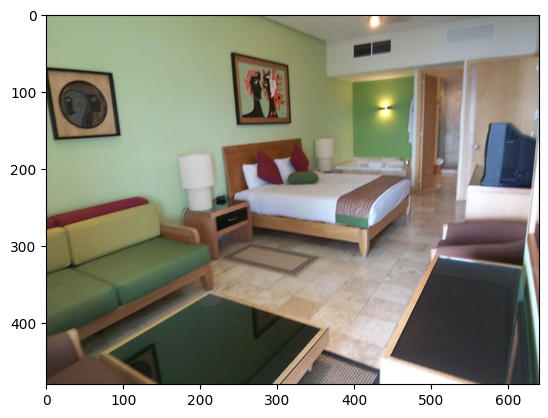

In [5]:
plt.imshow(hotel_img)

## Caption

In [6]:
uio.caption(hotel_img)["text"]

INFO:absl:Running model text_inputs=['What does the image describe ?']


'a hotel room with a bed and a couch in it.'

In [7]:
!nvidia-smi

Thu May 25 16:44:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  Off |
|  0%   47C    P2   146W / 450W |  19883MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## VQA

In [6]:
uio.vqa(hotel_img, "what color is the couch?")["text"]

INFO:absl:Running model text_inputs=['what color is the couch?']


'green.'

## Image Classification

In [7]:
# Image classification support a list of answer options to support different category sets
out = uio.image_classification(hotel_img, answer_options=["hotel room", "pool", "bedroom"])
out

INFO:absl:Running model text_inputs=['What is this in the image ?'] and 3 answer options


{'text': 'hotel room', 'score': array([5.6741896], dtype=float32)}

## Region Classification

Input location:


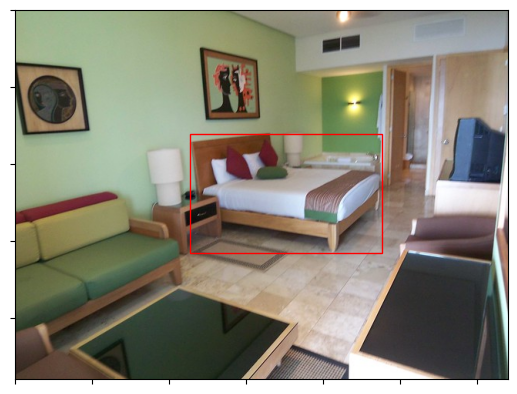

INFO:absl:Running model text_inputs=['What is the category of region " <extra_id_350> <extra_id_453> <extra_id_593> <extra_id_843> " ?'] and 3 answer options


'bed'

In [8]:
box = [226.56, 160.64, 476.16, 316.16]
print("Input location:")
show_location(hotel_img, np.array([box]))
out = uio.region_classification(hotel_img, box, answer_options=["bed", "chair", "sofa"])
out["text"]

## Depth

INFO:absl:Running model text_inputs=['What is the depth map of the image ?']


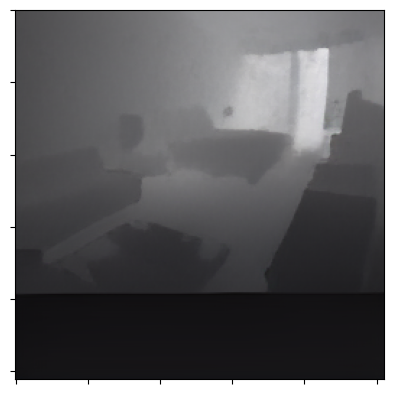

In [9]:
out = uio.depth(hotel_img, num_decodes=None)
show_images(out["image"])

INFO:absl:Running model text_inputs=['What is the depth map of the image ?']


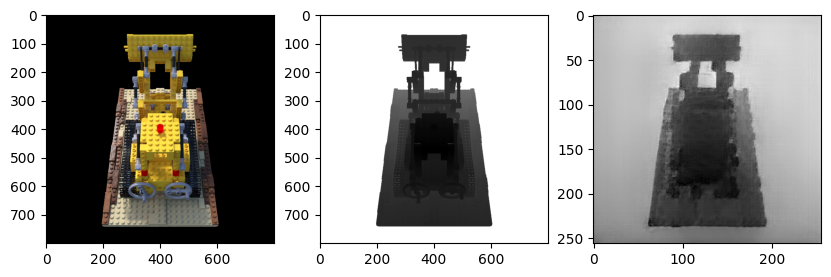

In [80]:
# 図と軸の配列を作成
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
img_path = "/data/dataset/HICO-DET/images/test2015/HICO_test2015_00000014.jpg"
img_path = "/home/ito/NeRF/data/nerf_synthetic/lego/test/r_0.png"
img = Image.open(img_path).convert('RGB')
img = np.array(img)
axes[0].imshow(img)
img_path = "/home/ito/NeRF/data/nerf_synthetic/lego/test/r_0_depth_0001.png"
d_img = Image.open(img_path).convert('L')
d_img = np.array(d_img)
axes[1].imshow(d_img, cmap='gray_r')
out = uio.depth(img, num_decodes=None)

# グレースケールに変換
image_gray = np.dot(out["image"], [0.2989, 0.587, 0.114])
axes[2].imshow(image_gray, vmin=image_gray.min(), vmax=image_gray.max(), cmap='gray')
plt.show()

## Surface

INFO:absl:Running model text_inputs=['What is the surface normal of the image ?']


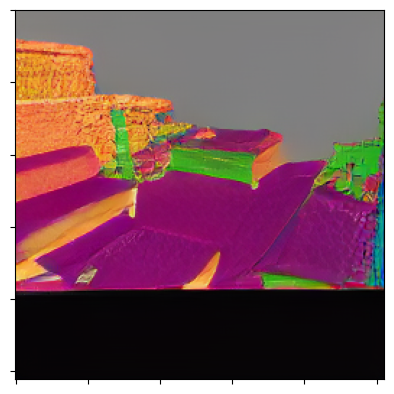

In [10]:
out = uio.surface_normal(hotel_img)
show_images(out["image"])

## Image Generation

INFO:absl:Running model text_inputs=['What is the complete image? Text: " A horse in a grassy field. " .']


shape: text_logits (1, 1, 49536)
text_logits: [[[-3.6760366e+00 -2.6536388e+00 -3.1415620e+00 ... -1.0000000e+10
   -1.0000000e+10 -1.0000000e+10]]]
shape: image_logits (1, 256, 49536)
image_logits: [[[-1.0000000e+10 -1.0000000e+10 -1.0000000e+10 ... -1.7797821e+01
   -1.7807455e+01 -1.7799095e+01]
  [-1.0000000e+10 -1.0000000e+10 -1.0000000e+10 ... -3.4906307e+01
   -3.4933880e+01 -3.4906326e+01]
  [-1.0000000e+10 -1.0000000e+10 -1.0000000e+10 ... -4.2398106e+01
   -4.2435390e+01 -4.2403675e+01]
  ...
  [-1.0000000e+10 -1.0000000e+10 -1.0000000e+10 ... -1.9064653e+01
   -1.9069262e+01 -1.9064352e+01]
  [-1.0000000e+10 -1.0000000e+10 -1.0000000e+10 ... -2.1100183e+01
   -2.1115355e+01 -2.1106047e+01]
  [-1.0000000e+10 -1.0000000e+10 -1.0000000e+10 ... -2.4544405e+01
   -2.4562262e+01 -2.4545149e+01]]]
transformer output image shape: (4, 256)
vocab minus image shape: (4, 256)
vocab minus image: [[10997  2922  6660 ... 15525  9710  8517]
 [ 2481  1635 14257 ...  9407  9407  2443]
 [ 1765

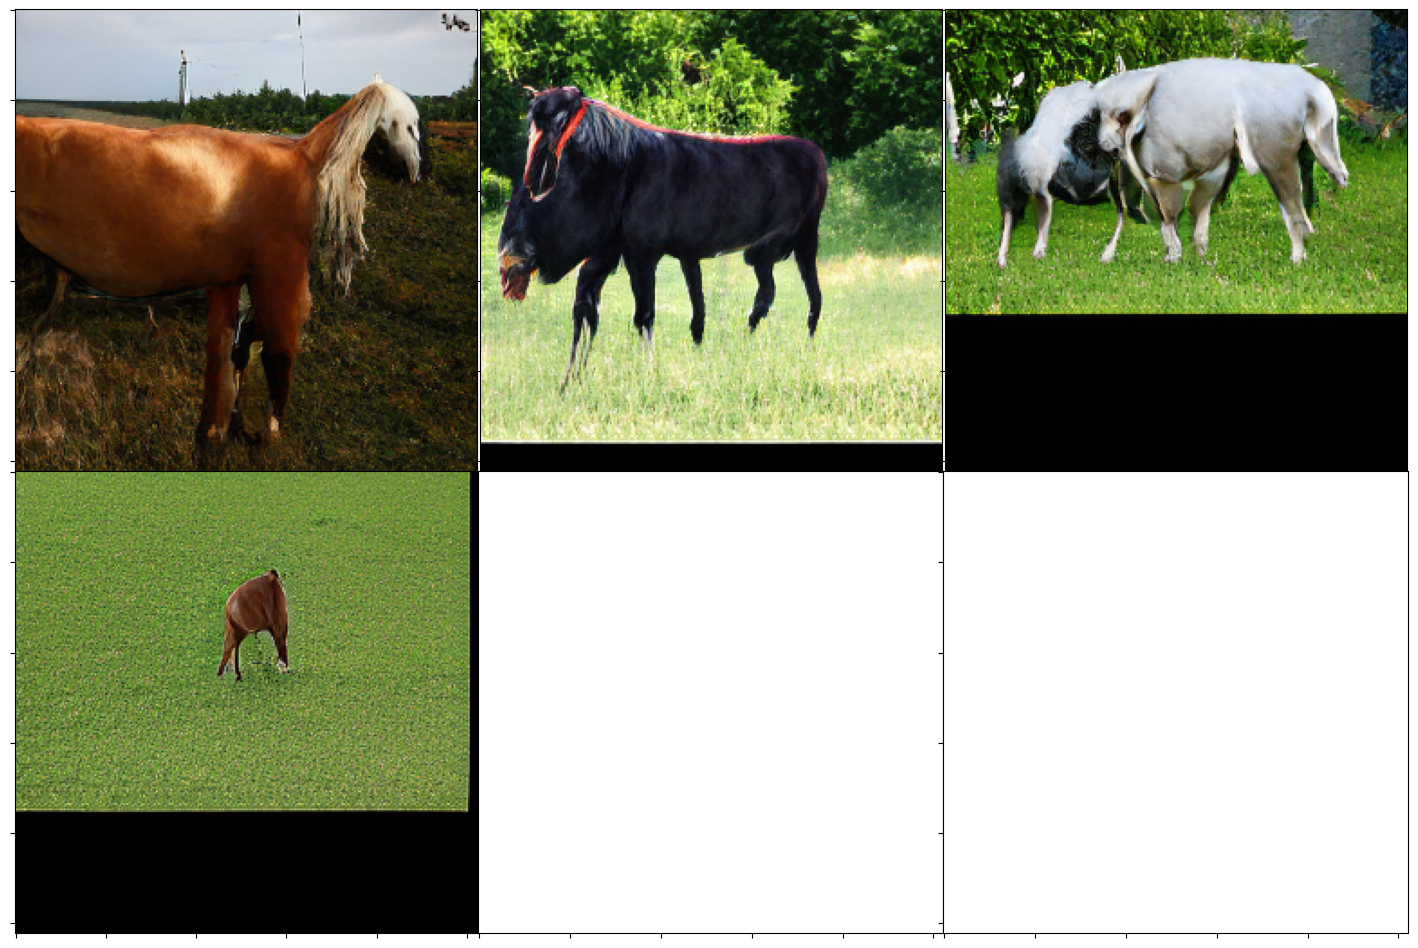

In [4]:
out = uio.image_generation("A horse in a grassy field.", num_decodes=4)
show_images(out["image"])

## Object Segmentation

INFO:absl:Running model text_inputs=['What is the segmentation of " painting " ?']


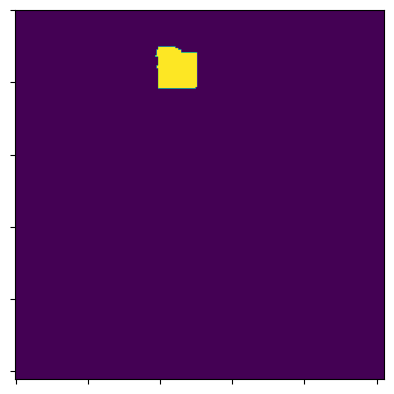

In [12]:
out = uio.object_segmentation(hotel_img, "painting")
# show_images(out["image"])
# print(out["mask"])
# mask will be a list of binary masks, on for each instance
show_images(np.expand_dims(np.stack(out["mask"]), -1))

## Visual Grounding

INFO:absl:Running model text_inputs=['Which region does the text " bed " describe ?']


{'boxes': array([[228.48, 161.92, 475.52, 316.16]]), 'text': ['<extra_id_352><extra_id_456><extra_id_593><extra_id_842>bed'], 'score': array([[-13.225773]], dtype=float32), 'text_tokens': array([[[32747, 32643, 32506, 32257,  1953,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1, 41016]]], dtype=int32)}


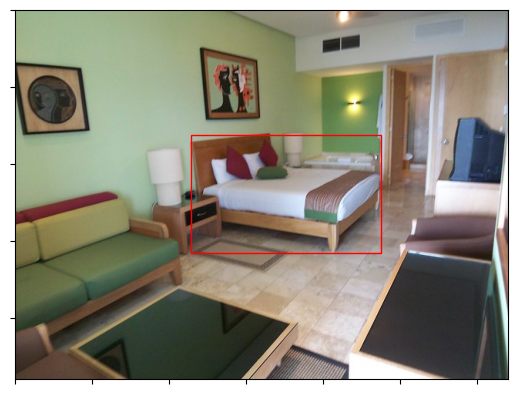

In [27]:
out = uio.refexp(hotel_img, "bed")
print(out)
show_location(hotel_img, out["boxes"])

## Region Caption

In [14]:
out = uio.region_caption(hotel_img, box)
out["text"]

INFO:absl:Running model text_inputs=['What does the region " <extra_id_350> <extra_id_453> <extra_id_593> <extra_id_843> " describe ?']


'a bed with a white sheet'

## Key Points

INFO:absl:Running model text_inputs=['Find the human joints in the region " <extra_id_274> <extra_id_101> <extra_id_931> <extra_id_515> " .']


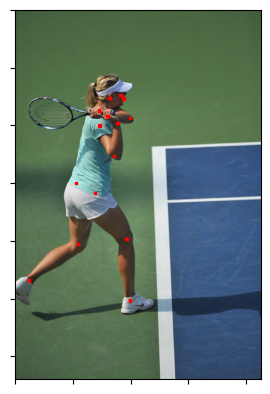

In [15]:
box = [1, 112, 266, 533]
out = uio.pose(tennis_img, box)
show_pose(out["points"], out['labels'], tennis_img)

## Image Inpainting

INFO:absl:Running model text_inputs=['Filling the blank region " <extra_id_350> <extra_id_453> <extra_id_593> <extra_id_843> table " ?']


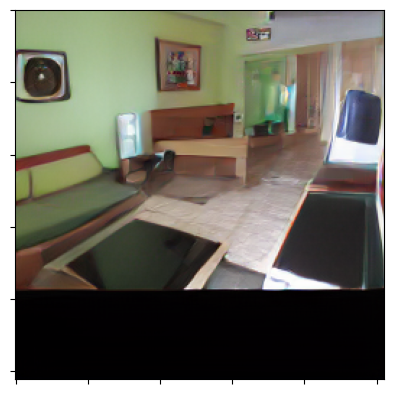

In [16]:
box = [226.56, 160.64, 476.16, 316.16]
out = uio.image_inpainting(hotel_img, box, "table", 1)
show_images(out["image"])

## Segmentation based Generation

INFO:absl:Running model text_inputs=['What is the complete image? Segmentation color: " penguin : white "']


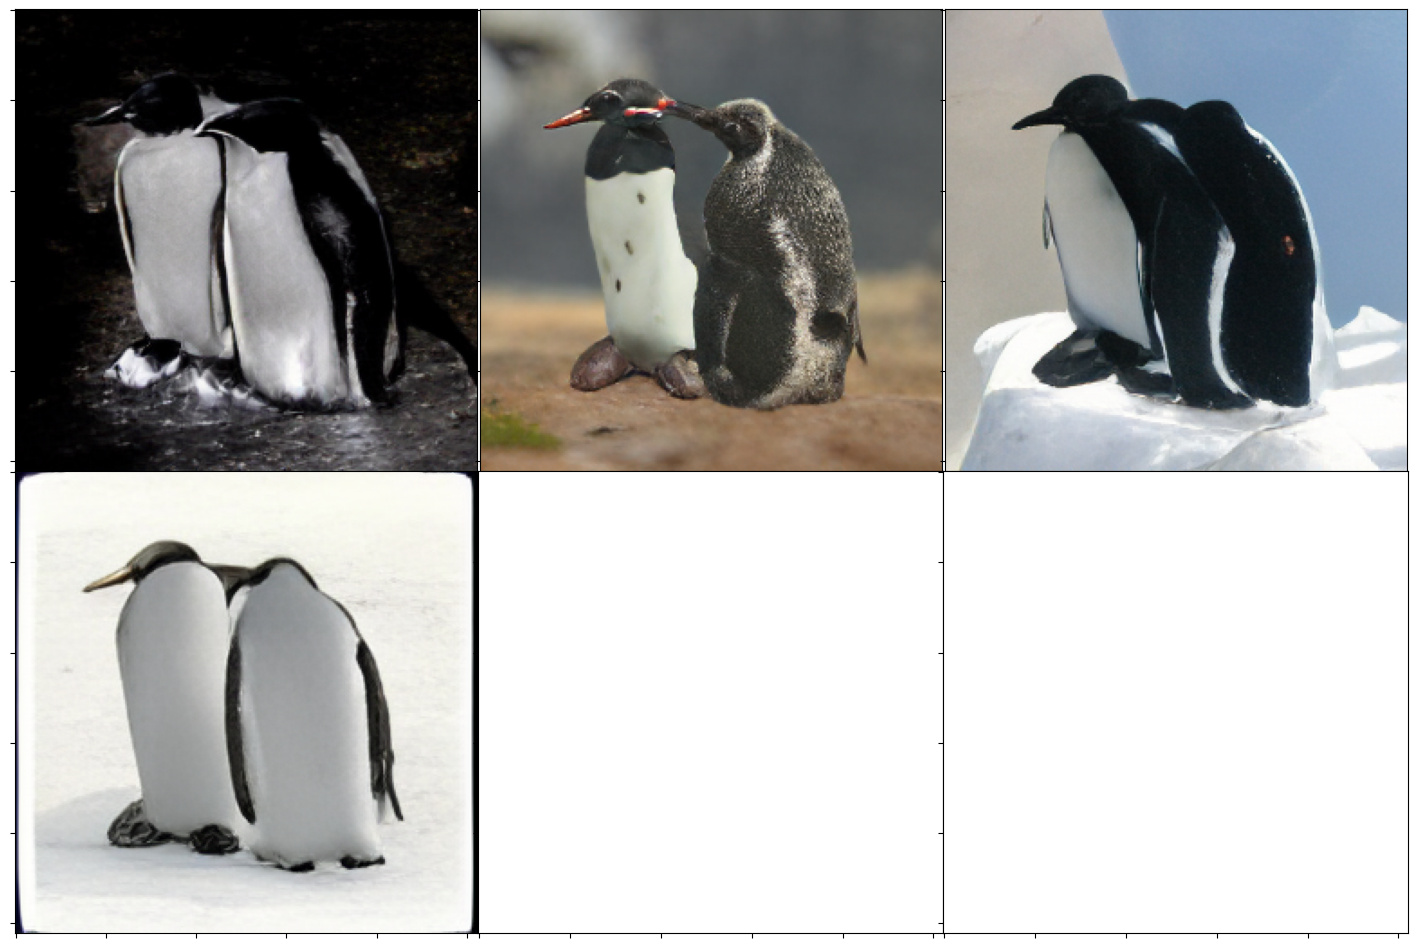

In [17]:
# image = read_image('dbg_penguin_outline.jpg').numpy().transpose(1, 2, 0)
out = uio.segmentation_based_generation([penguin_img[:, :, 0] > 10], ["penguin"], num_decodes=4)
show_images(out["image"])

## Detection

In [19]:
out = uio.run([hotel_img], ['What objects are in the image ?'], output_text_len=128, generate_image=False)
print(out)
# show_location(hotel_img, out["boxes"])

INFO:absl:Running model text_inputs=['What objects are in the image ?']


{'text_tokens': array([[[ 3100,  6452,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,   239,  1953,     1,     1,     1,     1,   239,
          1953,     1,     1,     1,     1,     1,   239,  1953,     1,
           239,  1953,     1,   239,  1953,     1,     1,   239,  1953,
             1,     1,   239,  1953,     1,   23

## Relation

In [5]:
import csv

with open('/data/dataset/HICO-DET/list_action.txt', 'r') as f:
  reader = csv.reader(f)
  hois = []
  for i, row in enumerate(reader):
    if i < 2:
      continue
    hois.append(row[0].split()[1].replace('_', ' '))

print(hois)

['adjust', 'assemble', 'block', 'blow', 'board', 'break', 'brush with', 'buy', 'carry', 'catch', 'chase', 'check', 'clean', 'control', 'cook', 'cut', 'cut with', 'direct', 'drag', 'dribble', 'drink with', 'drive', 'dry', 'eat', 'eat at', 'exit', 'feed', 'fill', 'flip', 'flush', 'fly', 'greet', 'grind', 'groom', 'herd', 'hit', 'hold', 'hop on', 'hose', 'hug', 'hunt', 'inspect', 'install', 'jump', 'kick', 'kiss', 'lasso', 'launch', 'lick', 'lie on', 'lift', 'light', 'load', 'lose', 'make', 'milk', 'move', 'no interaction', 'open', 'operate', 'pack', 'paint', 'park', 'pay', 'peel', 'pet', 'pick', 'pick up', 'point', 'pour', 'pull', 'push', 'race', 'read', 'release', 'repair', 'ride', 'row', 'run', 'sail', 'scratch', 'serve', 'set', 'shear', 'sign', 'sip', 'sit at', 'sit on', 'slide', 'smell', 'spin', 'squeeze', 'stab', 'stand on', 'stand under', 'stick', 'stir', 'stop at', 'straddle', 'swing', 'tag', 'talk on', 'teach', 'text on', 'throw', 'tie', 'toast', 'train', 'turn', 'type on', 'walk

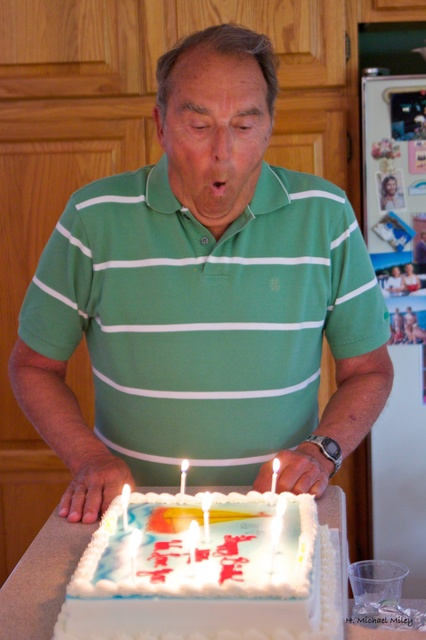

In [6]:
img_path = "/data/dataset/HICO-DET/images/test2015/HICO_test2015_00000009.jpg"
img = Image.open(img_path)
display(img)
img = np.array(img)

INFO:absl:Running model text_inputs=['Which region does the text " cake " describe ?']


['<extra_id_863><extra_id_193><extra_id_1096><extra_id_598>cake']


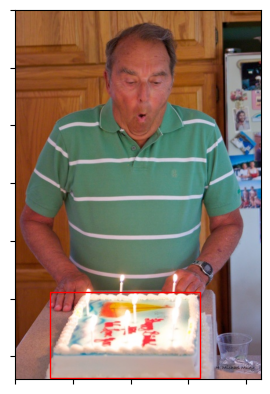

INFO:absl:Running model text_inputs=['Which region does the text " person " describe ?']


['<extra_id_131><extra_id_111><extra_id_918><extra_id_717>person']


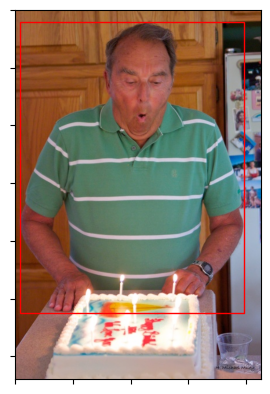

INFO:absl:Running model text_inputs=['What is the relation ship between " <extra_id_863> <extra_id_193> <extra_id_1096> <extra_id_598> cake " and " <extra_id_131> <extra_id_111> <extra_id_918> <extra_id_717> person " ?'] and 117 answer options


{'text_tokens': array([[[539,   1,   0,   0,   0]]], dtype=int32), 'text': ['open'], 'image_tokens': None, 'image': array(None, dtype=object), 'score': array([[31.826736]], dtype=float32), 'all_scores': array([[[50.965824, 48.786533, 45.507805, 42.729385, 34.95427 ,
         40.5925  , 64.71591 , 53.477654, 45.746273, 42.94268 ,
         44.265816, 49.46002 , 39.96493 , 46.95233 , 41.523266,
         40.674633, 51.418003, 43.70643 , 54.96071 , 51.095524,
         56.663902, 51.746284, 47.558605, 41.723488, 54.207558,
         46.489037, 49.63034 , 53.52139 , 52.647385, 47.98413 ,
         58.569656, 49.296535, 54.074905, 44.736427, 50.97417 ,
         39.74005 , 40.908016, 55.79174 , 48.003876, 39.332275,
         53.17196 , 56.81874 , 57.299072, 58.63699 , 50.818565,
         46.284534, 67.02901 , 50.00277 , 59.835472, 52.517677,
         54.079296, 44.238914, 54.93358 , 51.686947, 49.54366 ,
         46.461132, 53.835014, 44.073574, 31.826736, 53.391388,
         45.014545, 47.93162 

In [7]:
object_out = uio.refexp(img, "cake")
print(object_out['text'])
show_location(img, object_out["boxes"])

person_out = uio.refexp(img, "person")
print(person_out['text'])
show_location(img, person_out["boxes"])

relation_out = uio.run([img], [f"What is the relation ship between \" {object_out['text'][0].replace('>', '> ')} \" and \" {person_out['text'][0].replace('>', '> ')} \" ?"], answer_options=hois)
print(relation_out)